### CLASSIFICATION

In [11]:
# открываем clean_df с part_3
import pandas as pd
clean_df= pd.read_csv('part_3.csv')
clean_df.drop('Unnamed: 0',inplace = True,axis = 1)
print(clean_df.shape)
clean_df['checked_churn'].value_counts()

(531, 33)


0    369
1    162
Name: checked_churn, dtype: int64

In [10]:
# открываем feature_df с part_3
import pandas as pd
feature_df= pd.read_csv('part_2_feature_df.csv')
feature_df.drop('Unnamed: 0',inplace = True,axis = 1)
print(feature_df.shape)
feature_df.head(1)

(531, 3455)


,able,able get,able help,able redeem,able watch,absolutely,absolutely horrendous,absolutely suck,acce,access,...,zip code,𝐋𝐄𝐀𝐃𝐄𝐑,location_proba,rfm,sin_time,cos_time,text_len,topic,fact,polarity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.003766,331,-0.002982,0.999996,51,14,1,-0.15


In [9]:
# checked_churn = list(clean_df['checked_churn'])
# feature_df['checked_churn'] = checked_churn
# feature_df['checked_churn'].value_counts()

0    369
1    162
Name: checked_churn, dtype: int64

In [12]:
# делааем split 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_x, valid_x, train_y, valid_y = \
    train_test_split(feature_df, clean_df['checked_churn'], \
    test_size=0.2, random_state=45)

In [40]:
valid_y.shape

(107,)

In [13]:
# разбивка у train и valid +- одинаковая
print(train_y.value_counts()/train_y.shape[0])
print(valid_y.value_counts()/valid_y.shape[0])
print(len(train_x))
print(len(valid_x))

0    0.698113
1    0.301887
Name: checked_churn, dtype: float64
0    0.682243
1    0.317757
Name: checked_churn, dtype: float64
424
107


In [25]:
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve,precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV


In [53]:
# объявим словарь, куда будем собирать roc_auc
r_a = dict()

###   наивный байес

In [54]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_x,train_y)
y_pred_nb =nb.predict(valid_x)
print('для наивного Байеса', roc_auc_score(valid_y, y_pred_nb))
r_a['NB'] = roc_auc_score(valid_y, y_pred_nb)

для наивного Байеса 0.45729250604351335


In [56]:
norm_nb = MultinomialNB()
norm_nb.fit(norm_train_x,norm_train_y)
norm_y_pred_nb =norm_nb.predict(norm_valid_x)

print('для наивного Байеса', roc_auc_score(norm_valid_y, norm_y_pred_nb))
r_a['norm_NB'] = roc_auc_score(norm_valid_y, norm_y_pred_nb)

для наивного Байеса 0.45729250604351335


###  логистическая регрессия 

In [57]:

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_x,train_y)
y_pred_lr =lr.predict(valid_x)

print('для логистической регрессии', roc_auc_score(valid_y, y_pred_lr))
r_a['lr'] = roc_auc_score(valid_y, y_pred_lr)

для логистической регрессии 0.84709911361805


In [32]:
import matplotlib.pyplot as plt 
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass

def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

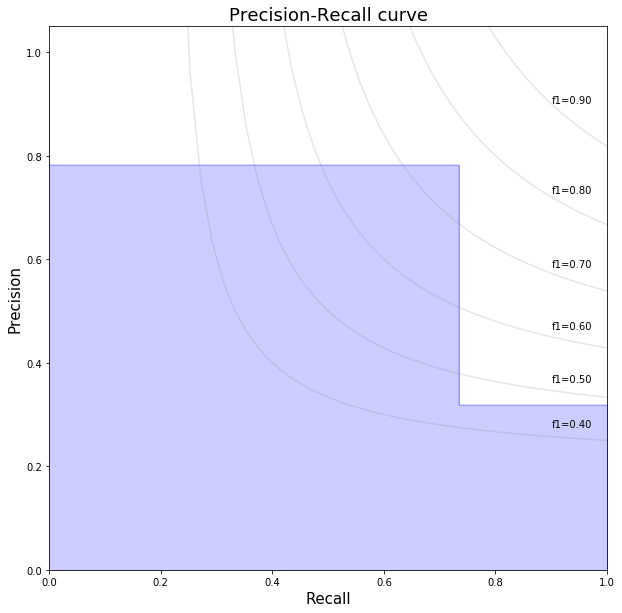

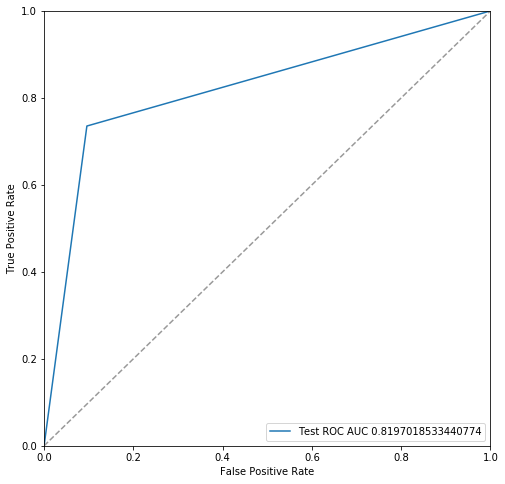

In [31]:

plot_precision_recall_curve(y_pred_lr, valid_y)
roc_auc_pic(y_pred_lr, valid_y)

In [29]:
# Решётка для перебора параметра 
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr, param_grid, cv = 5)
grid_cv_lr.fit(train_x, train_y)

print('Лучшее значение параметра регуляризации:', grid_cv_lr.best_params_)

# Сделали прогнозы
y_pred_lr_grid = grid_cv_lr.predict(valid_x)

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

Лучшее значение параметра регуляризации: {'C': 5}


C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [58]:
print('для логистической регрессии с grid_search', roc_auc_score(valid_y, y_pred_lr_grid))
r_a['gs_lr'] = roc_auc_score(valid_y, y_pred_lr_grid)

для логистической регрессии с grid_search 0.8491136180499598


#### нормирование данных

In [33]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

# Он сам будет считать максимумы, минимумы и делить! 

# Объеявили скалировшик 
scaler = MinMaxScaler( )

# Обучили его на тренировочной выборке (он само посчитал все максимумы, минимумы, поделил)
scaler.fit(feature_df) 

# Теперь применяем его к нашим данным 
norm_feature_df = pd.DataFrame(scaler.transform(feature_df),columns =list(feature_df.columns) )
norm_feature_df.shape

(531, 3455)

In [36]:
norm_train_x, norm_valid_x, norm_train_y, norm_valid_y = \
    train_test_split(norm_feature_df, clean_df['checked_churn'], \
    test_size=0.2, random_state=45)

In [41]:
norm_valid_y.shape

(107,)

In [65]:
norm_lr = LogisticRegression()
norm_lr.fit(norm_train_x,norm_train_y)
norm_y_pred_lr =norm_lr.predict(norm_valid_x)

print('для логистической регрессии с нормированеми данными', roc_auc_score(norm_valid_y, norm_y_pred_lr))
r_a['norm_lr'] = roc_auc_score(norm_valid_y, norm_y_pred_lr)

для логистической регрессии с нормированеми данными 0.84709911361805


In [44]:
# Решётка для перебора параметра 
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
grid_cv_lr = GridSearchCV(norm_lr, param_grid, cv = 5)
grid_cv_lr.fit(norm_train_x, norm_train_y)

print('Лучшее значение параметра регуляризации:', grid_cv_lr.best_params_)

# Сделали прогнозы
norm_y_pred_lr_grid = grid_cv_lr.predict(norm_valid_x)


Лучшее значение параметра регуляризации: {'C': 10}


In [60]:
print('для логистической регрессии с grid_search и нормированием', roc_auc_score(norm_valid_y, norm_y_pred_lr_grid))
r_a['norm__gs_lr'] = roc_auc_score(norm_valid_y, norm_y_pred_lr_grid)

для логистической регрессии с grid_search и нормированием 0.8843674456083803


### Решающее дерево

In [61]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(norm_train_x, norm_train_y)

norm_pred_rf = rnd_clf.predict(norm_valid_x)
print('для решающего дерева', roc_auc_score(norm_valid_y, norm_pred_rf))
r_a['DT'] = roc_auc_score(norm_valid_y, norm_pred_rf)

для решающего дерева 0.8607977437550363


In [64]:
r_a

{'NB': 0.45729250604351335,
 'norm_NB': 0.45729250604351335,
 'lr': 0.84709911361805,
 'gs_lr': 0.8491136180499598,
 'norm_lr': 0.84709911361805,
 'norm__gs_lr': 0.8843674456083803,
 'DT': 0.8607977437550363}

In [78]:
roc_auc = pd.DataFrame(r_a,index=[0]).transpose()
roc_auc.rename(columns={0:'roc_auc'})

,roc_auc
NB,0.457293
norm_NB,0.457293
lr,0.847099
gs_lr,0.849114
norm_lr,0.847099
norm__gs_lr,0.884367
DT,0.860798


In [46]:
# confusion_matrix - Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[69  4]
 [ 6 28]]


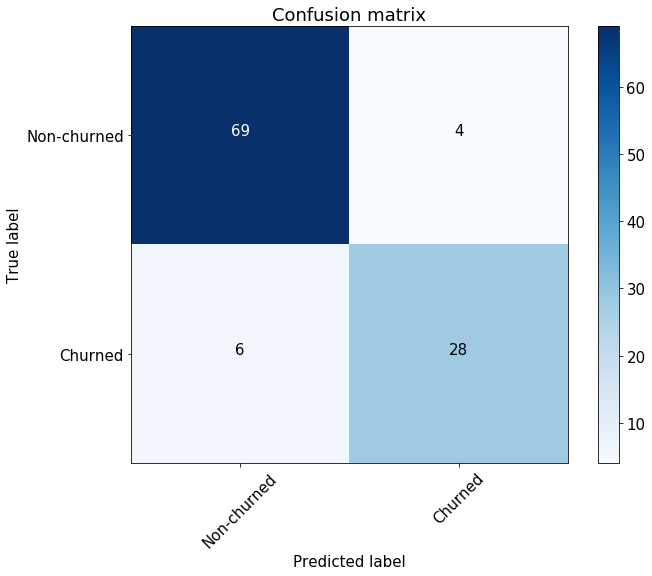

In [47]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(norm_valid_y, norm_y_pred_lr_grid)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
# Classification Models and Success metrics
  

  
def model(classifier, train_vector, valid_vector,train_y,valid_y):
    classifier.fit(train_vector, train_y)  
    predict_y = classifier.predict(valid_vector)
    accuracy = accuracy_score(valid_y, predict_y)
    precision = precision_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    recall = recall_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    conf_matrix = confusion_matrix(valid_y, predict_y)
    print('\nAccuracy_score: {:.3f}'.format(accuracy ))
    print('precision_score: {:.3f}'.format(precision.mean()))
    print('recall_score: {:.3f}'.format(recall.mean()))
    print('roc_auc_score',roc_auc_score(valid_y, predict_y))
    print('\nconfusion_matrix: \n')
    
    print(confusion_matrix(valid_y, predict_y))
    print(classification_report(valid_y, predict_y))
    
    return roc_auc_pic(predict_y, valid_y),plot_precision_recall_curve(predict_y, valid_y)

# roc_auc_pic

def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass
# roc_auc_pic(y_pred_lr, valid_y)


# precision_recall

def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()
# plot_precision_recall_curve(y_pred_lr, valid_y)

In [ ]:
model(LogisticRegression(), train_x, valid_x,train_y,valid_y)

In [ ]:
# .naive_bayes
from sklearn.naive_bayes import MultinomialNB
model(MultinomialNB(), train_x, valid_x,train_y,valid_y)

In [ ]:
# xgboost
from xgboost import XGBClassifier
model(XGBClassifier(), train_x, valid_x,train_y,valid_y)

In [ ]:
import lightgbm as gbm

params_gbm = {
    "objective": 'binary',
    "max_depth": 4,
    "min_child_weight" : 2,
    "n_estimators": 200,
    "learning_rate": 0.05,
    'early_stopping_round':20,
    'metric':'auc'
    }

d_train = gbm.Dataset(train_x, label=train_y, free_raw_data = False)

model2 = gbm.train(params_gbm, d_train)

In [ ]:
y_pred = model2.predict(valid_x)
print(roc_auc_score(valid_y,y_pred))